In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append('../')
import pandas as pd
from src.io import (load_dataframe, save_dataframe)
from src.viz import plot_colored_trajectory
from src.preprocessing import compute_phases,smooth_trajectory_savgol

In [3]:
with open('../data/processed/embedding.pkl', "rb") as f:
        emb = pickle.load(f)
# find the spectrum of the stochastic matrix
eig_val,eig_vec = np.linalg.eig(emb.P)
real_spectrum = np.real(eig_val)
# sort the eigen system according to the value of the real part
eig_vec = eig_vec[np.argsort(real_spectrum)]
real_spectrum = real_spectrum[np.argsort(real_spectrum)]
slow_mode = eig_vec[-2]

In [19]:
print(np.cumsum(emb.P[0]))
print(emb.P[0])
print(np.searchsorted(np.cumsum(emb.P[0]), 0.75, side='right'))

[0.50684932 0.50684932 0.50684932 0.54794521 0.54794521 0.54794521
 0.7260274  0.7260274  0.7260274  0.7260274  0.7260274  0.7260274
 0.7260274  0.7260274  0.81506849 0.81506849 0.81506849 0.81506849
 0.81506849 0.81506849 0.81506849 0.81506849 0.81506849 0.81506849
 0.81506849 0.81506849 0.82191781 0.82191781 0.82191781 0.82191781
 0.82191781 0.82191781 0.82191781 0.82191781 0.82191781 0.82191781
 0.82191781 0.82191781 0.82191781 0.82191781 0.82191781 0.94520548
 0.94520548 0.94520548 0.98630137 1.         1.         1.
 1.         1.        ]
[0.50684932 0.         0.         0.04109589 0.         0.
 0.17808219 0.         0.         0.         0.         0.
 0.         0.         0.0890411  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00684932 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.12328767
 0.         0.         0.041

In [3]:
# Path to raw copepod tracking data
df = load_dataframe('../data/interim/longest_trajectory.csv')
df.head()

,label,x,y,z,u,v,w,frame,speed,curvature_angle,torsion_angle,abs_torsion_angle
0,3108,26.144965,42.800918,-11.825039,2.759621,-1.476744,-5.764880,1080465,0.092103,0.022514,0.000000,0.000000
1,3108,26.148874,42.787235,-11.738907,2.630041,-1.334178,-3.569576,1080466,0.082705,0.026778,0.026778,0.026778
2,3108,26.154377,42.774436,-11.662049,2.297801,-1.257121,-0.520242,1080467,0.073729,0.032273,0.032273,0.032273
3,3108,26.161404,42.762486,-11.594102,1.980169,-1.354051,2.444283,1080468,0.065188,0.039484,0.039484,0.039484
4,3108,26.169883,42.751353,-11.534699,2.095226,-1.571031,6.451247,1080469,0.057106,0.049134,0.049134,0.049134


Text(0.5, 0, 'z')

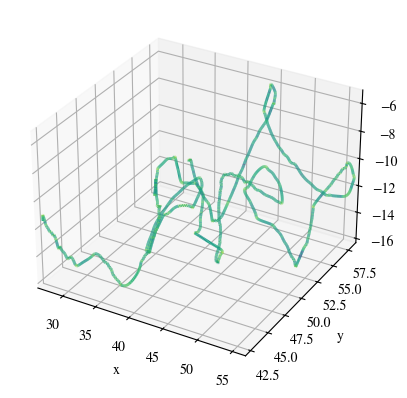

In [5]:
ax = plt.subplot(projection='3d')
plot_colored_trajectory(ax,df,'x','y','z',color_col='curvature_angle',
                        logscale=True,sort_col='frame',linewidth=2)
#ax.scatter(df['x'],df['y'],df['z'],s=2,color='black')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(45,45.5)
#ax.set_ylim(53,55)
#ax.set_zlim(-6,-4.)

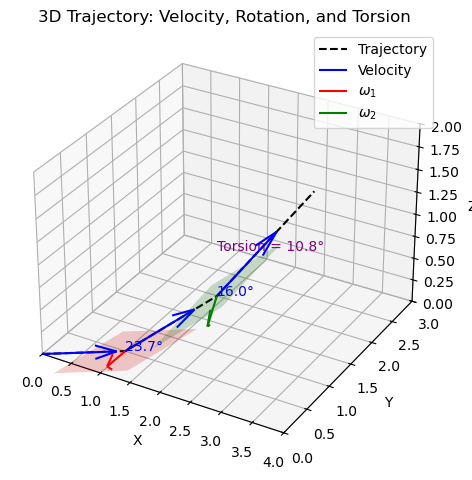

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Define 4 trajectory points
X = np.array([
    [0, 0, 0],
    [1, 0.5, 0],
    [2, 1.2, 0.5],
    [3, 2.0, 1.5]
])

# Compute tangent vectors
v1 = X[1] - X[0]
v2 = X[2] - X[1]
v3 = X[3] - X[2]
T1 = v1 / np.linalg.norm(v1)
T2 = v2 / np.linalg.norm(v2)
T3 = v3 / np.linalg.norm(v3)

# Rotation axes (normal to turning plane)
n1 = np.cross(T1, T2)
n1 /= np.linalg.norm(n1)
n2 = np.cross(T2, T3)
n2 /= np.linalg.norm(n2)

# Rotation angle (between T1 and T2)
angle1 = np.arccos(np.clip(np.dot(T1, T2), -1.0, 1.0)) * 180 / np.pi
angle2 = np.arccos(np.clip(np.dot(T2, T3), -1.0, 1.0)) * 180 / np.pi

# Torsion angle (between n1 and n2)
torsion_angle = np.arccos(np.clip(np.dot(n1, n2), -1.0, 1.0)) * 180 / np.pi

# Rotation planes (each spanned by two tangent vectors)
plane1_origin = X[1]
plane1_vecs = np.vstack([T1, T2])
plane2_origin = X[2]
plane2_vecs = np.vstack([T2, T3])

def plot_plane(ax, origin, vecs, color, alpha=0.3):
    grid_size = 0.5
    u, v = vecs
    grid_u = np.linspace(-grid_size, grid_size, 2)
    grid_v = np.linspace(-grid_size, grid_size, 2)
    uu, vv = np.meshgrid(grid_u, grid_v)
    plane = origin + uu[..., None] * u + vv[..., None] * v
    ax.plot_surface(
        plane[..., 0], plane[..., 1], plane[..., 2],
        alpha=alpha, color=color, edgecolor='none'
    )

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Trajectory
ax.plot(*X.T, 'k--', label='Trajectory')

# Tangents
for i, (x, v) in enumerate(zip(X[:3], [v1, v2, v3])):
    ax.quiver(*x, *v, color='b', length=1.0, normalize=True, label='Velocity' if i == 0 else "")

# Angular velocity (rotation) vectors
ax.quiver(*X[1], *n1, color='r', length=1.0, normalize=True, label=r'$\omega_1$')
ax.quiver(*X[2], *n2, color='g', length=1.0, normalize=True, label=r'$\omega_2$')

# Rotation angles
ax.text(*X[1], f"{angle1:.1f}°", color='blue')
ax.text(*X[2], f"{angle2:.1f}°", color='blue')

# Torsion angle
ax.text(*X[2] + [0, 0, 0.5], f"Torsion = {torsion_angle:.1f}°", color='purple')

# Plot rotation planes
plot_plane(ax, plane1_origin, plane1_vecs, color='red', alpha=0.2)
plot_plane(ax, plane2_origin, plane2_vecs, color='green', alpha=0.2)

# Axes settings
ax.set_xlim(0, 4)
ax.set_ylim(0, 3)
ax.set_zlim(0, 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("3D Trajectory: Velocity, Rotation, and Torsion")
ax.legend()
plt.tight_layout()
plt.show()
